# STAT 520B Final Project
## VarGrad: the Gradient Estimator of the Log-Variance Loss Divergence
Grace Yin

This project aims to explore the variance of the $VarGrad$, which is the gradient estimator of the log-variance loss. To accomplish this mission, this project includes background knowledge of the log-variance, and simulation tests of the $VarGrad$ on logistic models and finite Gaussian mixture models. Finally, this report gives future directions to the studies on the $VarGrad$.

In [2]:
using Pkg
Pkg.add("Distributions")
Pkg.add("Flux")
Pkg.add("Zygote")

   Updating registry at `~/.julia/registries/General`
######################################################################### 100.0%
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


In [3]:
using Flux,Distributions,LinearAlgebra,ForwardDiff,Zygote,Plots,ForwardDiff,SpecialFunctions,Calculus

## Tests on a Logistic Regression Model

$$ \log p(y,X,z)
    =\sum_{i=1}^{N}[y_i \log(\sigma(z^Tx_i)+(1-y_i)\log(1-g(z^Tx_i))]+\sum_{j=1}^Pp(z_j|\mu=0,\sigma=1)$$
$$\log q(z|\lambda)=\sum_{j=1}^{P}\log p(z_j|\mu_j,\sigma_j^2)$$ where $z$ can be sampled from $q(z|\lambda)\sim \mathcal{N}(\mu,\text{diag}(\sigma^2))$. The gradient estimators for $\mu$ and $\sigma$ are 
$$\nabla_{\mu_j}\log q(z|\lambda)=\frac{z_j-\mu_j}{\sigma_j^2},$$ $$\nabla_{\sigma}\log q(z|\lambda)=\left(-\frac{1}{2\sigma_j^2}+\frac{(z_j-\mu_j)^2}{2(\sigma_j^2)^2}\right)\sigma_j^2$$

In [4]:
function sigmoid(z::Array)
    "This is the helper sigmoid function"
    return 1.0 ./ (1.0 .+ exp.(-z))
end

sigmoid (generic function with 1 method)

In [8]:
function BBVI_grad(z_sample, μ, σ)
    "This function is used to compute the BBVI gradient estimator for logistic regression"
    score_mu = (z_sample.-μ)./σ
    score_logsigma =((σ.*2).^(-1)+((z_sample.-μ).^2)./(2*σ.^2)).*σ
    log_p = sum(y.*log.(sigmoid(X*z_sample))+ (-y.+1).*log.(-sigmoid(sigmoid(X*z_sample)).+1))
        + sum(logpdf.(Normal.( zeros(P), ones(P)),z_sample))
    log_q = sum(logpdf.(Normal.(μ, σ),z_sample))
    ∇μ = score_mu*(log_p - log_q)
    ∇σ = score_logsigma
    return [vcat(∇μ, ∇σ)]
end

BBVI_grad (generic function with 1 method)

In [9]:
function estimator(mu, sigma)
    "mini-batch size for BBVI is 10"
    samples1 = rand.(Normal.(mu,sqrt.(sigma)))
    samples2 = rand.(Normal.(mu,sqrt.(sigma)))
    samples3 = rand.(Normal.(mu,sqrt.(sigma)))
    samples4 = rand.(Normal.(mu,sqrt.(sigma)))
    samples5 = rand.(Normal.(mu,sqrt.(sigma)))
    samples6 = rand.(Normal.(mu,sqrt.(sigma)))
    samples7 = rand.(Normal.(mu,sqrt.(sigma)))
    samples8 = rand.(Normal.(mu,sqrt.(sigma)))
    samples9 = rand.(Normal.(mu,sqrt.(sigma)))
    samples10 = rand.(Normal.(mu,sqrt.(sigma)))
    a=BBVI_grad(samples1, mu, sigma)
    b=BBVI_grad(samples2, mu, sigma)
    c=BBVI_grad(samples3, mu, sigma)
    d=BBVI_grad(samples4, mu, sigma)
    e=BBVI_grad(samples5, mu, sigma)
    f=BBVI_grad(samples6, mu, sigma)
    g=BBVI_grad(samples7, mu, sigma)
    h=BBVI_grad(samples8, mu, sigma)
    i=BBVI_grad(samples9, mu, sigma)
    j=BBVI_grad(samples10, mu, sigma)
    M=vcat(a,b,c,d,e,f,g,h,i,j)
    grad=mean(M,dims=1)
    return mean(M,dims=1)
    
end

estimator (generic function with 1 method)

In [10]:
function var_obj(h, ψ)
    "This function computes the variance of the log ratio functions"
    z_sample = rand.(Normal.(h[1],sqrt.(exp.(h[2]))),100)
    z_sample =Zygote.dropgrad(z_sample)
    score_mu = (z_sample.-ψ[1])./ψ[2]
    score_logsigma =(((ψ[2].*2).^(-1)).+((z_sample.-ψ[1]).^2)./(2*ψ[2].^2)).*ψ[2]
    log_p = y.*log.(sigmoid(X.*z_sample))+ (-y.+1).*log.(-sigmoid(sigmoid(X.*z_sample)).+1)
        + logpdf.(Normal.( zeros(P), ones(P)),z_sample)
    log_q = logpdf.(Normal.(ψ[1], ψ[2]),z_sample)
    return 0.5*var(log_p.-log_q)
end

var_obj (generic function with 1 method)

In [11]:
function var_grad(h,ψ)
    "Taking the gradient of the variance of the log ratio functions lead to the gradient estimator VarGrad"
    ∇l=(h,ψ)-> ForwardDiff.gradient(z -> var_obj(h,z),ψ )
    return ∇l(h,ψ)
end 

var_grad (generic function with 1 method)

In [18]:
P=1
h=rand(2)
ψ=rand(2)
N = 100
X = randn(N,P)
z_real = randn(P)
M=sigmoid(X*z_real)
y=zeros(100)
for i in 1:100
    y[i]=rand(Binomial(1,M[i]))
end

In [19]:
S = 10
n_iter = 10000
mu = randn(P)
G = zeros((2*P,2*P))
eta = 1.0
log_sigma = randn(P)
mus = zeros((n_iter,P))
delta_lambda = zeros(n_iter)
sigma = exp.(log_sigma)

1-element Array{Float64,1}:
 1.1408391338395916

### Plot the variance of the BBVI gradient estimators and the VarGrad

In [20]:
A=zeros(100)
for t in 1:100
    for i in 1:t
        B = zeros(t)
        B[i]=norm(estimator(mu,sigma))
        A[t]=var(B)
    end
end
A2=zeros(100)
for t in 1:100
    for i in 1:t
        B = zeros(t)
        B[i]=norm(var_grad(h,ψ))
        A2[t]=var(B)
    end
end

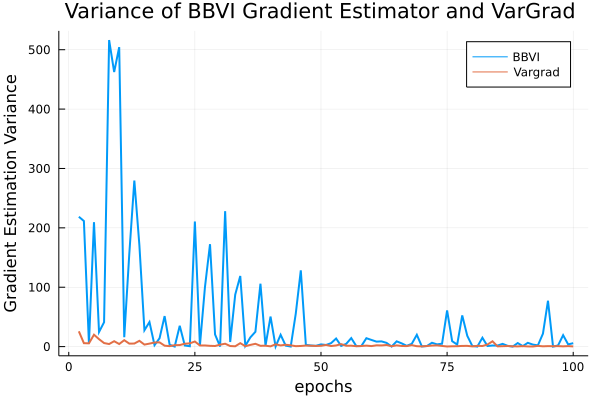

In [21]:
plot(1:1:100, [A,A2], lw=2, label = ["BBVI" "Vargrad"],title="Variance of BBVI Gradient Estimator and VarGrad ",xlabel="epochs", ylabel="Gradient Estimation Variance",linewidth=1.5)

## Tests on a Gaussian Mixture Model with 3 Components
$$\mu_k \sim \mathcal{N}(0,\sigma^2), \ c_i \sim \text{Categorical}(1/K,\cdots, 1/K),\ x_i|c_i,\mu \sim \mathcal{N}(c_i^T\mu,1)$$
$$q(\mu,c)=\prod_{k=1}^{K}q(\mu_k;m_k,s_k^2)\prod_{i=1}^{n}q(c_i;\varphi_i)$$
$$m_k^{*}=\frac{\sum_{i}\varphi_{ik}x_i}{1/\sigma^2+\sum_{i}\varphi_{ik}}$$ and $$s_k^2=\frac{1}{1/\sigma^2+\sum_{i}\varphi_{ik}}$$

In [24]:
function CAVI_grad(X,phi,m,s2)
    "This function is to compute the CAVI gradient estimator"
    #A=zeros(300,3)
    #a=(exp.(transpose(-0.5*(m.^2+s2)).+kron(transpose(m),X)))
    #A[:,1]=a[:,1]/sum(a[:,1])
    #A[:,2]=a[:,2]/sum(a[:,2])
    #A[:,3]=a[:,3]/sum(a[:,3])
    #∇ϕ=A
    ∇m =[sum((phi[:,1]).*X)/((1+sum(phi[:,1]))),sum((phi[:,2]).*X)/((1+sum(phi[:,2]))),sum((phi[:,3]).*X)/((1+sum(phi[:,3])))]
    ∇s2=[(1+sum(phi[:,1]))^(-1),(1+sum(phi[:,2]))^(-1),(1+sum(phi[:,3]))^(-1)]
    return ∇m,∇s2
    
    #return vcat(∇ϕ,transpose(∇m),transpose(∇s2))
end

CAVI_grad (generic function with 1 method)

In [30]:
function mix_obj(X,phi,m,s2)
    "This function is used to compute the variance of the log-ratio functions"
    X =Zygote.dropgrad(X)
    log_p=(log.(s2)).-m
    log_q1 = -0.5*(kron(transpose(s2+m.^2),X))
    log_q = (log_q1.+ (kron(transpose([m[1],m[2],m[3]]),X)).-log.(phi)).*phi
    return 0.5*var(transpose(log_p).+log_q)
end

mix_obj (generic function with 1 method)

In [31]:
function Var_grad(X,phi,m,s2)
    "Taking the gradient of the variance to get VarGrad"
    ∇l=(X,phi,m,s2)-> ForwardDiff.gradient(z -> mix_obj(X,phi,z,s2),m )
    ∇h=(X,phi,m,s2)-> ForwardDiff.gradient(z -> mix_obj(X,phi,m,z),s2 )
    #∇k=(X,phi,m,s2)-> ForwardDiff.gradient(z -> mix_obj(X,z,m,s2),phi )
    #∇K=∇k./sum(∇k)
    #return hcat(∇l(X,phi,m,s2),∇h(X,phi,m,s2),∇K(X,phi,m,s2))
    return ∇l(X,phi,m,s2), ∇h(X,phi,m,s2)
end 

Var_grad (generic function with 1 method)

In [57]:
mu_arr=rand(-10:.1:10, 3)
X1=rand(Normal(mu_arr[1],1),100)
X2=rand(Normal(mu_arr[2],1),100)
X3=rand(Normal(mu_arr[3],1),100)
X_=append!(X1,X2)
X=append!(X_,X3)
m=rand(minimum(X):.1:maximum(X),3)+maximum(X)*rand(3)
phi=transpose(rand(Dirichlet([1,2,3]),300))
s2=rand(3)

3-element Array{Float64,1}:
 0.15655047571374325
 0.5495095966208479
 0.6638650612337842

In [64]:
A_VarGrad=zeros(100)
for t in 1:100
    for i in 1:t
        B = zeros(t)
        B[i]=norm(Var_grad(X,phi,m,s2))
        A_VarGrad[t]=var(B)
    end
end

In [65]:
A_CAVI=zeros(100)
for t in 1:100
    for i in 1:t
        B = zeros(t)
        B[i]=norm(CAVI_grad(X,phi,m,s2))
        A_CAVI[t]=var(B)
    end
end

### Plot the variance of the BBVI gradient estimators and the VarGrad

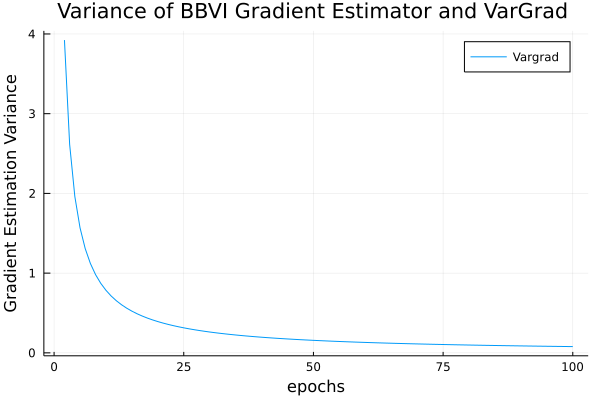

In [66]:
plot([A_VarGrad], lw=1, label = "Vargrad",title="Variance of BBVI Gradient Estimator and VarGrad ",xlabel="epochs", ylabel="Gradient Estimation Variance",linewidth=1.5)

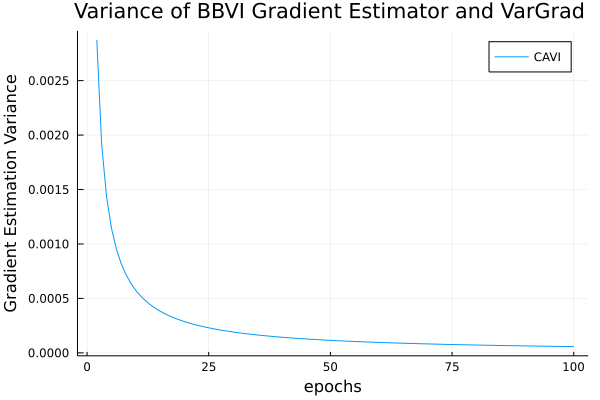

In [67]:
plot([A_CAVI], lw=1, label =  "CAVI",title="Variance of BBVI Gradient Estimator and VarGrad ",xlabel="epochs", ylabel="Gradient Estimation Variance",linewidth=1.5)

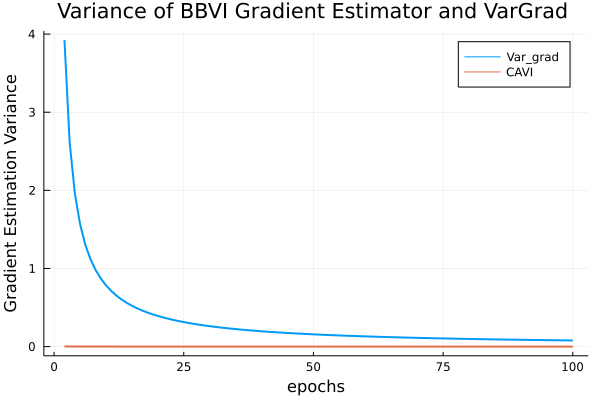

In [68]:
plot([A_VarGrad,A_CAVI], lw=2, label = ["Var_grad" "CAVI"],title="Variance of BBVI Gradient Estimator and VarGrad ",xlabel="epochs", ylabel="Gradient Estimation Variance",linewidth=1.5)

## Tests of the New Gradient Estimator of the Log-Variance Loss
\begin{align*}
    &\hat{\nabla}_{\phi}\mathcal{L}_r(q_{\phi}(z)||p(z|x))=\frac{1}{2}\nabla_{\phi}Var_{r}\left(\log \left(\frac{q_{\phi}(z)}{p(z|x)}\right)\right)\\&=\frac{1}{2}\nabla_{\phi}\int \log^2\left(\frac{q_{\phi}(z)}{p(z|x)}\right)q_{\phi}(z)dz-\frac{1}{2}\nabla_{\phi}\left(\int \log \left(\frac{q_{\phi}(z)}{p(z|x)}\right)q_{\phi}(z)dz\right)^2\\&=\int\log\left(\frac{q_{\phi}(z)}{p(z|x)}\right)\nabla q_{\phi}(z)+\log^2\left(\frac{q_{\phi}(z)}{p(z|x)}\right)\nabla q_{\phi}(z)dz\\&=-\left(\int \log \left(\frac{q_{\phi}(z)}{p(z|x)}\right)q_{\phi}(z)dz\right)\left(\int \nabla q_{\phi}(z)\left(1+\log \left(\frac{q_{\phi}(z)}{p(z|x)}\right)\right)dz\right)
\end{align*}

In [69]:
function grad1(h,ψ)
    "New gradient estimator"
    y = rand(Beta(exp(h[1]+1),exp(h[2]+1)))
    logπ = x -> logpdf(Beta(1, 9), x)
    logqψ = (x,ψ) -> logpdf(Beta(exp(ψ[1])+1,exp(ψ[2])+1), x)
    ∇logqψ=(y, ψ)-> ForwardDiff.gradient(m -> logqψ(y,m), ψ)
    ∇logρψ = (y, ψ) -> ∇logqψ(y, ψ)*(logqψ(y,ψ)-logπ(y)+1)
    return ∇logρψ(y, ψ)
end
    

grad1 (generic function with 1 method)

In [70]:
function reparametrization(h,ψ)
    "Re-parametrization gradient estimator"
    y = rand(Beta(exp(h[1]+1),exp(h[2]+1)))
    y2 = rand(Beta(exp(h[1]+1),exp(h[2]+1)))
    y3 = rand(Beta(exp(h[1]+1),exp(h[2]+1)))
    logπ = x -> logpdf(Beta(1, 9), x)
    ∇logqψ=(y, ψ)-> ForwardDiff.gradient(m -> logqψ(y,m), ψ)
    qψ  = (y, ψ)->exp.(logpdf(Beta(exp(ψ[1])+1,exp(ψ[2])+1), y))
    ∇qψ = (y,ψ)->ForwardDiff.gradient(z -> qψ(y,z),ψ)
    logqψ=(y,ψ)->logpdf(Beta(exp(ψ[1]+1),exp(ψ[2]+1)), y)
    return (((∇qψ(y,ψ).*(logqψ(y,ψ)-logπ(y))+∇qψ(y,ψ).*(logqψ(y,ψ)-logπ(y)).^2)/qψ(y, ψ)).-(((logqψ(y2,ψ)-logπ(y2)).*∇qψ(y3,ψ).*(1+logqψ(y3,ψ)-logπ(y3)))/qψ(y3, ψ)))
    #return (∇qψ(y,ψ).+∇qψ(y,ψ).*(log.(y)-logπ.(y))-∇qψ(y,ψ).*(log.(y)-logπ.(y))*y*(1+log.(y)-logπ.(y)))
end

grad2 (generic function with 1 method)

In [71]:
function gradient_variance(h,ψ)
    "Compute the variance of these two gradient estimators"
    logπ = x -> logpdf(Beta(1,9), x)
    N=100
    g1=zeros(N)
    g2=zeros(N)
    for i in 1:N
        g1[i]=norm(reparametrization(h,ψ))
        g2[i]=norm(grad2(h,ψ))
       
    end
    return var(g1),var(g2)
end   

gradient_variance (generic function with 1 method)

### Plot the variance of the new gradient estimator and re-parametrization gradient estimator

In [86]:
A=zeros(100,2)
B=zeros(100,2)
B0=zeros(30,2)
A[:,1]=repeat([1],100)
A[:,2]=1.1:0.1:11
for i in 1:100
    B[i,1]=gradient_variance(A[i,:],A[i,:])[1]
    B[i,2]=gradient_variance(A[i,:],A[i,:])[2]
    B0=B[1:30,:]
end


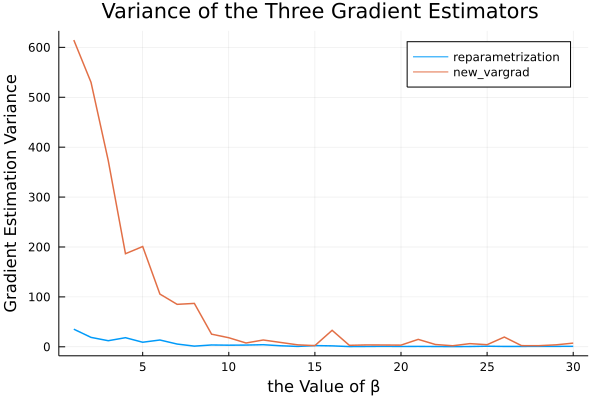

In [87]:
plot( [B0[:,1], B0[:,2]] , label = ["reparametrization" "new_vargrad"] ,title="Variance of the Three Gradient Estimators ",xlabel="the Value of β", ylabel="Gradient Estimation Variance",linewidth=1.5)

In [88]:
A=zeros(100,2)
C=zeros(100,2)
A[:,1]=1.1:0.1:11
A[:,2]=repeat([5],100)
for i in 1:100
    C[i,1]=gradient_variance(A[i,:],A[i,:])[1]
    C[i,2]=gradient_variance(A[i,:],A[i,:])[2]
end

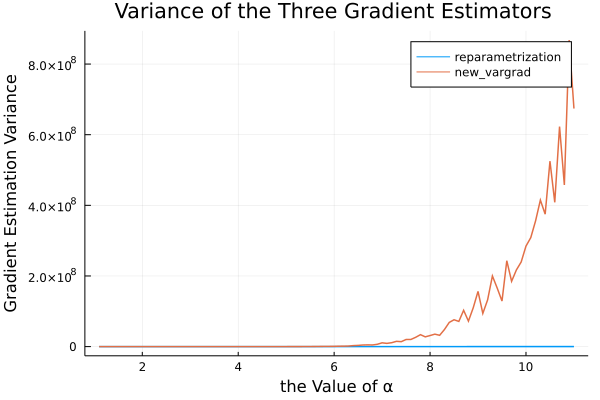

In [89]:
plot(1.1:0.1:11, [C[:,1], C[:,2]] , label = ["reparametrization" "new_vargrad"] ,title="Variance of the Three Gradient Estimators ",xlabel="the Value of α", ylabel="Gradient Estimation Variance",linewidth=1.5)